# Part 1: A Basic Gradient Boosting Algorithm
This is the first notebook in a series of notebooks which will go through Gradient Boosting and other variations.  Firstly, we will go through a basic implementation of the gradient boosting algorithm using decision trees (GBTs) as our base estimator.  We will be using Scikit-Learn's DecisionTreeRegressor to build the trees, for more info on their package click <a href="http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor">here</a>  . Our algorithm will then be compared to Scikit-Learn's algorithm.  The two should implementaions be identical because we are using their decision trees as our base estimator.

## Importing and Data Handling
First, we will import any neccessary packages and prepare our data for modelling.  Then we will split our dataset into Test and Training sets which will be used throughout all of the notebooks covering GBTs. The dataset used also comes from Scikit-Learn, for documentation see <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston">here</a>

In [1]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle

In [2]:
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * .9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
yi = y_train

## Gradient Boosting Brief Intro
Gradient Boosting is an additive ensembling method which builds on the previous iteration's error.  This implementation of the gradient boosting algorithm was introduced by Friedman<sup>[1]</sup> and was further outlined in "The Elements of Statistical Learning" by Hastie, Tibshirani, and Friedman<sup>[2]</sup>.  The book contains psuedo-code for gradient boosting which can be seen below:
![Oops Something is wrong](gbt_algorithm.PNG "GBT Algorithm")

However, this algorithm is not complete. A shrinkage parameter (also called the learning rate) was added to 2.d for regularization:
![Oops Something is wrong](gbt_shrinkage.PNG "GBT Algorithm")
The learning rate can be seen as a way to control the step size of each iteration.

In other words, we will be initializing the algorithm with a very weak estimator (commonly the mean/median) then obtaining the residuals (Actual - Predicted).  We will then iteratively fit the residuals (called pseudo-residuals for the iterations) with a shallow tree n times.  Each Epoch's prediction (The final prediction for that iteration) will be comprised of the last Epoch's prediction plus this iteration's prediction on the psuedo-residuals multiplied by the shrinkage rate.  The shrinkage rate is a parameter which must be tuned along with the tree depth, which is the same for each tree that is constructed. 

## Initialize Our Model Parameters
The cell below initializes the parameters and datasets that will be used in the algorithm. Comments have been added in the code for further details.

In [3]:
ei = 0 # initialization of error
predf = 0 # initial prediction 0
test_predictions = 0 # initial test set prediction 0
mse_list_adap = [] #Creating the mse data set
lr = .01 #Setting the Learning rate
test_predictions_list = pd.DataFrame([])

## Running the Algorithm

We are now ready to run the algorithm, it is just a loop where we have defined the parameters used as:
- <b>predf</b> is vector of of our final predictions at each iteration 
- <b>predi</b> is a vector of predictions on the previous iteration's residuals
- <b>lr</b> is the learning rate

In [6]:
for i in range(5000): # loop will make 5000 trees.
    tree = DecisionTreeRegressor(max_depth = 2) #Call Sklearn's decision tree 
    tree.fit(X_train,yi)
    predi =  tree.predict(X_train) #Training set predictions
    predicted =  tree.predict(X_test) #Test set predictions

    #The first model is just the median, subsequent models will be trees built on the pseudo-residuals
    if i == 0:
        predf = np.median(yi)
        test_predictions = np.median(yi)
    else:
        predf = predf + lr*predi  # Final prediction will be previous prediction value + new prediction of pseudo-residual
        test_predictions = test_predictions + lr*predicted #Final prediction on the Test Set.
        test_predictions_list[i] = test_predictions
    ei = y_train - predf  # Obtain the residual for the next iteration    
    yi = ei # Update our target variable to be the residual
    test_mse = (np.mean((y_test - test_predictions)**2)) #Calculate MSE
    mse_list_adap.append(test_mse)

## Comparing the Two Implementations
Now that we have run our algorithm, we will run Sklearn's for comparison.  Hopefully, the two give us identical results.  For the comparison we will be using the Test Set MSE for each iteration.

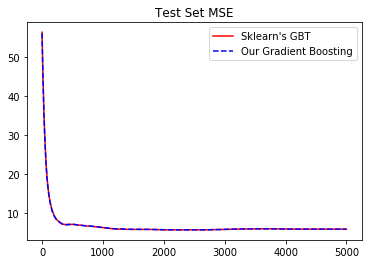

In [7]:
#List of the MSE's for each iteration
mse_list_adap = pd.DataFrame(mse_list_adap)

from sklearn.ensemble import GradientBoostingRegressor
n_est = 5000
#Building Sklearn's gradient boosting model with the same parameters
rnd_reg = GradientBoostingRegressor(max_depth=2, n_estimators=n_est, subsample = 1, learning_rate=.01)
rnd_reg.fit(X_train,y_train)
predictions = rnd_reg.predict(X_test)

test_score = [(np.mean((y_test - y_pred)**2)) for i, y_pred in enumerate(rnd_reg.staged_predict(X_test))]

    

plt.plot(test_score, label = "Sklearn's GBT", color = 'red')
plt.plot(mse_list_adap, label = 'Our Gradient Boosting', color = 'blue', linestyle = 'dashed')
plt.legend()
plt.title('Test Set MSE')
plt.show()

The graph above illustates the comparison of the two algorithms.  It appears that they are identical, which was the goal of our algorithm.  

## An illustration of Our Predictions Converging to the Actuals
Let's take a look at specifically our model's Test Set Actuals vs. Predictions.  One major drawback of gradient boosting is that we lose any interpretability that a simple decision tree gives us.  There is always a trade off in machine learning, and in this instance we have iterated away interpretability to achieve better prediction accuracy.  Due to this, 2 dimensional representations tend to not be insightful (unless of course the second dimension is Time) so we have chosen to represent the Test Set Actuals vs. Predicted as 1 dimensional number lines. The top number line illustrates each pairing of Predicted vs. Actual with a line representing distance drawn between them.  The bottom number line displays Predicted vs. Actuals.  The graph has been animated to show the predictions throughout the boosting procedure.  If you are viewing this on GitHub or as a PDF the animation will not show so please view this in a ipynb format. 

In [11]:
from matplotlib import animation, rc

test_predictions_list[test_predictions_list.columns[::50]].T
def animate(nframe):
  plt.cla()
  plt.scatter(data.iloc[nframe], np.zeros_like(data.iloc[nframe]),label = 'Predicted', alpha = .8, s = 22**2)
  plt.title('Test Actuals vs. Predictions')
  plt.scatter(y_test, np.zeros_like(y_test),label = 'Actuals', alpha = .2, s= 22**2)
  plt.xlim(0,60)
  plt.ylim(-.5,1.5)
  plt.yticks([])
  plt.legend()
  plt.plot([y_test,data.iloc[nframe]], np.ones_like([y_test,data.iloc[nframe]]),marker = "o",markersize = 15,alpha = .2);
  

anim = animation.FuncAnimation(plt.figure(figsize=(8,6)), animate, frames=100);
rc('animation', html='html5')

In [12]:
anim

The next notebook will go through an implementaion of Stochastic Gradient Boosting following a similar procedure.

Citations
1. Friedman, J. H. "Greedy Function Approximation: A Gradient Boosting Machine." (February 1999)
2. Hastie, T.; Tibshirani, R.; Friedman, J. H. (2009). "10. Boosting and Additive Trees". The Elements of Statistical Learning (2nd ed.). New York: Springer. pp. 337–384. ISBN 0-387-84857-6.